# **Notebook for plotting results generated with GRRR notebooks**

First, we import all the results we want into a workable structure so we can easily index dimensions we need for plots

In [1]:
#! Note: misschien zijn de GloFAS resultaten ookwel te plotten door ze handmatig in te voeren?

In [2]:
from typing import List, Tuple, Dict, Any
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [3]:
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Georgia'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Georgia'
mpl.rcParams['mathtext.it'] = 'Georgia:italic'
mpl.rcParams['mathtext.bf'] = 'Georgia:bold'

In [4]:
def read_results(
    model: str,                 # either 'GFH' or 'GloFAS_v3' or 'GloFAS_v4'
    type: str,                  # either 'IMPACT' or 'OBS'
    geojson: bool = False,      # if True, returns the results with GeoJSON information included
                                # list of lead times to read the results for
    lead_time: List[int] = [1, 2, 3, 4, 5, 6, 7],
                                # list of return periods to read the results for
    return_period: List[float] = [1.5, 2, 5, 10, 95, 98, 99]
) -> Dict[str, pd.DataFrame]:
    """ Reads the results from the .csv files and return in dictionary with handy keys """
    if model not in ['GFH', 'GloFAS_v3', 'GloFAS_v4']:
        raise ValueError("Model must be either 'GFH', 'GloFAS_v3' or 'GloFAS_v4'")
    if type not in ['IMPACT', 'OBS']:
        raise ValueError("Type must be either 'IMPACT' or 'OBS'")
    if not all(lt in [1, 2, 3, 4, 5, 6, 7] for lt in lead_time):
        raise ValueError("Lead time must be in [1, 2, 3, 4, 5, 6, 7]")
    if not all(rp in [1.5, 2, 5, 10, 95, 98, 99] for rp in return_period):
        raise ValueError("Return period must be in [1.5, 2, 5, 10, 95, 98, 99]")

    print(model, type)
    d = {}
    for lt in lead_time:
        for rp in return_period:
            if rp in [1.5, 2, 5, 10]:
                rp_str = f'{rp}rp'
            else:
                rp_str = f'{rp}pc'

            if not geojson:
                key = f'{model}_vs_{type}_{lt * 24}lt_{rp_str}'
                d[key] = pd.read_csv(f'../data/results/{key}.csv', index_col = 0)
            else:
                key = f'{model}_vs_{type}_{lt * 24}lt_{rp_str}'
                d[key] = gpd.read_file(f'../data/results_geojson/{key}.geojson')
    return d

In [5]:
d_GFH_IMPACT = read_results(model = 'GFH', type = 'IMPACT')

print(next(iter(d_GFH_IMPACT.values())).head())

GFH IMPACT
  identifier  TP  FP  FN    POD  FAR  precision     f1 admin_unit_NAME
0     ML0101   0   0   1  0.000  NaN        NaN    NaN       BAFOULABE
1     ML0103   0   2   3  0.000  1.0        0.0    NaN          SANDIA
2     ML0105   0   1   1  0.000  1.0        0.0    NaN            KITA
3     ML0107   0   0   2  0.000  NaN        NaN    NaN        YELIMANE
4     ML0202   1   0   5  0.167  0.0        1.0  0.286          DIOILA


In [6]:
def get_metrics_for_configuration(
        d: Dict[str, pd.DataFrame], # the dictionary with the results
        type: str,                  # the type of results, e.g. 'GFH_vs_IMPACT'
        row: str,                   # where to get the metric for, i.e. in 'identifier' a location or 'total'
        metric: str,                # the metric to calculate (TP, FP, FN, POD, FAR, precision, f1)
    ) -> pd.DataFrame:
    """ Returns metric dataframe with dimensions (lead_time, return_period) """
    if not any(key.startswith(type) for key in d.keys()):
        raise ValueError("Type must be in the keys of the dictionary")
    if row not in next(iter(d.values()))['identifier'].unique():
        raise ValueError("Row must be in the identifier column of the dataframe")
    if metric not in ['TP', 'FP', 'FN', 'POD', 'FAR', 'precision', 'f1']:
        raise ValueError("Metric must be in ['TP', 'FP', 'FN', 'POD', 'FAR', 'precision', 'f1']")
    
    lts = ['24lt', '48lt', '72lt', '96lt', '120lt', '144lt', '168lt']
    rps = ['95pc', '98pc', '99pc', '1.5rp', '2rp', '5rp', '10rp']
    df = pd.DataFrame(index = lts, columns = rps)
    
    for lt in lts:
        for rp in rps:
            key = f'{type}_{lt}_{rp}'
            df.loc[lt, rp] = d[key][d[key]['identifier'] == row][metric].values[0]
    return df

In [7]:
df_GFH_IMPACT_POD_total = get_metrics_for_configuration(
    d               = d_GFH_IMPACT,
    type            = 'GFH_vs_IMPACT',
    row             = 'total',
    metric          = 'POD'
)

print(df_GFH_IMPACT_POD_total)

        95pc   98pc   99pc  1.5rp    2rp    5rp   10rp
24lt   0.209  0.127  0.082  0.155  0.145  0.036  0.009
48lt     0.2  0.118  0.064  0.145  0.127  0.036  0.018
72lt     0.2  0.127  0.082  0.155  0.145  0.036  0.018
96lt     0.2  0.118  0.064  0.155  0.109  0.036  0.009
120lt  0.173  0.109  0.055  0.155  0.109  0.036  0.009
144lt  0.182    0.1  0.055  0.136  0.109  0.036  0.009
168lt  0.182  0.109  0.055  0.155  0.118  0.036  0.009


In [8]:
def add_hline_across_subplots(fig, ax_ref, y, ax_left, ax_right, label, **line_kwargs):
    # LLM-generated code:
    import matplotlib.lines as mlines
    display_coords = ax_ref.transData.transform((0, y))
    y_fig = fig.transFigure.inverted().transform(display_coords)[1]
    bbox_left  = ax_left.get_position()
    bbox_right = ax_right.get_position()
    line = mlines.Line2D([bbox_left.x0, bbox_right.x1],
                         [y_fig, y_fig],
                         transform = fig.transFigure, **line_kwargs)
    fig.add_artist(line)

    if label:
        dummy_text = fig.text(0, 0, label, fontsize = 12)
        fig.canvas.draw()
        renderer = fig.canvas.get_renderer()
        bbox = dummy_text.get_window_extent(renderer=renderer)
        text_width_pixels = bbox.width
        fig_width_pixels = fig.get_figwidth() * fig.dpi
        text_width_frac = text_width_pixels / fig_width_pixels
        dummy_text.remove()
        x_text = bbox_right.x1 - text_width_frac
        fig.text(x_text - 0.005, y_fig + 0.015, label,
                 fontsize = 12, color = line_kwargs['color'])
        
        
def plot_PODFAR_over_treshold(
        df: pd.DataFrame,   # dataframe with the results
        row_to_plot,        # the row to plot, e.g. 'total' or a certain location
        y_str: str,         # y and x for naming the saved plot
        x_str: str,
        lead_time: int = 7, # lead time in days              
    ) -> None:
    """ Plots the POD over the thresholds """
    if y_str not in ['POD', 'FAR']:
        raise ValueError("y must be either 'POD' or 'FAR'")
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (4 * 1.618, 4))
    fig.subplots_adjust(wspace = 0.05)
    fs = 12

    columns = df.columns
    x_values = np.arange(len(columns))
    y_values = df.loc[row_to_plot, columns].values

    ax1.set_ylabel(y_str, fontsize = fs, fontweight = 'bold')
    ax1.plot(
        x_values[0 : 3], y_values[0 : 3],
        color = 'black', marker = '^', label = 'Google Flood Hub'
    )
    ax2.plot(
        x_values[3 : 7], y_values[3 : 7],
        color = 'black', marker = '^'
    )

    plt.tight_layout() # Note: place this at the right place in the script to not mess up manual lay-outing

    ax1.set_xlim(-0.5, 2.5)
    ax2.set_xlim(2.5, 6.5)
    ax1.set_xticks([0, 1, 2], fontsize = fs)
    ax1.set_xticklabels(['95%', '98%', '99%'], fontsize = fs)
    ax2.set_xticks([3, 4, 5, 6], fontsize = fs)
    ax2.set_xticklabels(['1.5-yr', '2-yr', '5-yr', '10-yr'], fontsize = fs)
    ax1.tick_params(axis = 'y', labelsize = fs)
    ax1.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax1.yaxis.tick_left()
    ax2.yaxis.tick_right()
    ax1.set_ylim(0, 1) if y_str == 'POD' else ax1.set_ylim(1, 0)
    ax1.legend(loc = 'upper left', fontsize = fs, frameon = False)
    ax1.text(0.00, 1.05, f'Lead time = {lead_time} days', ha = 'left', va = 'top',
        transform = ax1.transAxes, fontsize = fs
    )


    add_hline_across_subplots(
            fig, ax1, 0.5, ax1, ax2, label = "'Acceptable'",
            color = '#EB5B00', linestyle = '--', linewidth = 1.0
        )
    if y_str == 'POD':
        add_hline_across_subplots(
            fig, ax1, 0.6, ax1, ax2, label = "'Good'",
            color = '#0D4715', linestyle = '--', linewidth = 1.0
        )
    elif y_str == 'FAR':
        add_hline_across_subplots(
            fig, ax1, 0.3, ax1, ax2, label = "'Good'",
            color = '#0D4715', linestyle = '--', linewidth = 1.0
        )

    # https://matplotlib.org/stable/gallery/subplots_axes_and_figures/broken_axis.html
    d = 0.015
    kwargs = dict(transform = ax1.transAxes, color = 'k', clip_on = False)
    ax1.plot((1 - d, 1 + d), (-d, d), **kwargs)
    ax1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)
    kwargs = dict(transform = ax2.transAxes, color = 'k', clip_on = False)
    ax2.plot((-d, d), (1 - d, 1 + d), **kwargs)        
    ax2.plot((-d, d), (-d, d), **kwargs) 
    # --------------------------------------------------------------------------------

    plt.savefig(f'../data/figures/results_{y_str}_vs_{x_str}_{row_to_plot}_total.pdf',
                bbox_inches = 'tight', dpi = 300)
    plt.show()

        95pc   98pc   99pc  1.5rp    2rp    5rp   10rp
24lt   0.209  0.127  0.082  0.155  0.145  0.036  0.009
48lt     0.2  0.118  0.064  0.145  0.127  0.036  0.018
72lt     0.2  0.127  0.082  0.155  0.145  0.036  0.018
96lt     0.2  0.118  0.064  0.155  0.109  0.036  0.009
120lt  0.173  0.109  0.055  0.155  0.109  0.036  0.009
144lt  0.182    0.1  0.055  0.136  0.109  0.036  0.009
168lt  0.182  0.109  0.055  0.155  0.118  0.036  0.009


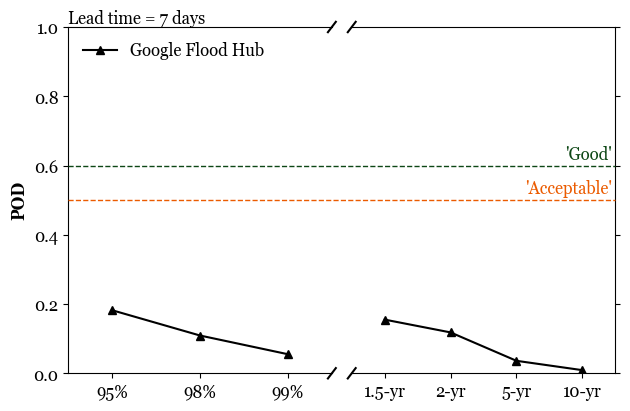

In [9]:
df_GFH_IMPACT_POD_total = get_metrics_for_configuration(
    d               = d_GFH_IMPACT,
    type            = 'GFH_vs_IMPACT',
    row             = 'total',
    metric          = 'POD'
)

print(df_GFH_IMPACT_POD_total)

plot_PODFAR_over_treshold(
    df              = df_GFH_IMPACT_POD_total,
    row_to_plot     = '168lt',
    y_str           = 'POD',
    x_str           = 'thr'
)

GFH OBS
        95pc   98pc   99pc  1.5rp    2rp    5rp 10rp
24lt   0.309  0.333  0.312  0.514  0.645  0.625  0.8
48lt   0.309  0.333  0.312  0.514  0.645  0.625  0.8
72lt   0.309  0.333  0.312  0.543  0.645  0.625  0.8
96lt   0.309  0.333  0.312  0.543  0.645  0.625  0.8
120lt  0.309  0.364  0.312  0.543  0.645  0.625  0.8
144lt  0.309  0.303  0.312  0.543  0.645  0.625  0.8
168lt  0.309  0.303  0.312  0.543  0.645  0.625  0.8


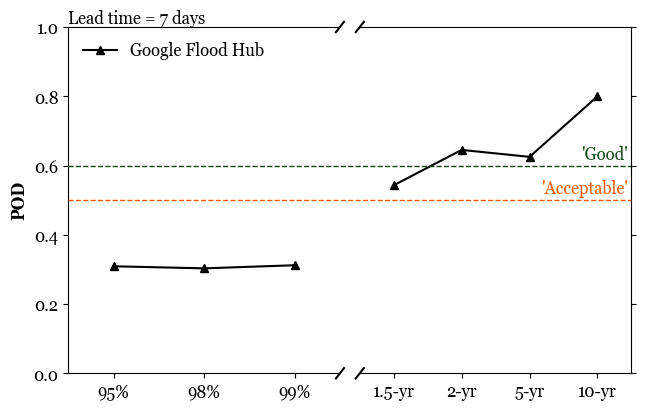

In [10]:
d_GFH_OBS = read_results(model = 'GFH', type = 'OBS')
df_GHF_OBS_POD_total = get_metrics_for_configuration(d = d_GFH_OBS, type = 'GFH_vs_OBS',
                                                     row = 'total', metric = 'POD')
print(df_GHF_OBS_POD_total) 

plot_PODFAR_over_treshold(df = df_GHF_OBS_POD_total, row_to_plot = '168lt', y_str = 'POD', x_str = 'thr')

        95pc   98pc   99pc  1.5rp    2rp    5rp   10rp
24lt   0.764  0.825  0.804  0.766  0.733  0.808  0.778
48lt   0.764  0.825  0.787  0.769  0.737  0.796  0.778
72lt   0.764  0.823  0.783  0.756  0.737    0.8  0.789
96lt   0.764  0.823  0.778  0.759  0.737    0.8  0.778
120lt  0.764  0.812  0.778  0.759   0.74  0.804    0.8
144lt  0.764  0.841  0.773  0.762   0.74    0.8  0.789
168lt  0.767  0.839  0.773  0.762  0.744  0.792  0.789


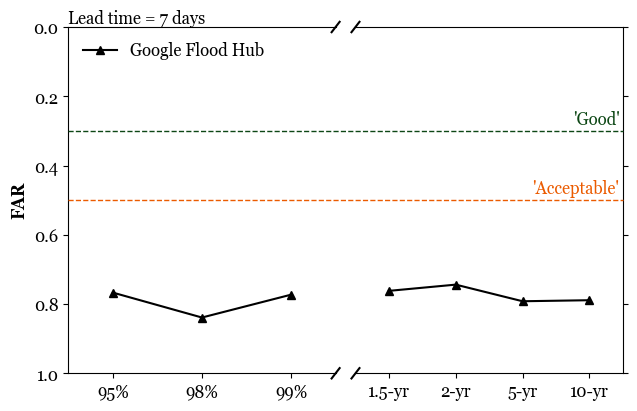

In [13]:
df_GFH_OBS_FAR_total = get_metrics_for_configuration(d = d_GFH_OBS, type = 'GFH_vs_OBS',
                                                     row = 'total', metric = 'FAR')
print(df_GFH_OBS_FAR_total)
plot_PODFAR_over_treshold(df = df_GFH_OBS_FAR_total, row_to_plot = '168lt', y_str = 'FAR', x_str = 'thr')